### Library imports

In [1]:
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoTokenizer, AutoModel
import torchvision.transforms as T
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import base64
import torch
import math
import os

### Function definitions

In [4]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

In [5]:
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

In [6]:
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

In [7]:
def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [8]:
## Function to display frames of accident

def display_images(image_paths, frame_x):

    if len(image_paths) > 50:
        raise ValueError("Please provide no more than 50 image paths.")

    num_images = len(image_paths)
    num_columns = 5
    num_rows = math.ceil(num_images / num_columns)

    # Create a figure with dynamic rows and fixed 5 columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.ravel()

    for i in range(num_rows * num_columns):

        if i < num_images:

            img = mpimg.imread(image_paths[i])  # Load image
            axes[i].imshow(img)                # Display image on the respective subplot
            axes[i].axis('off')                # Hide axes

            frame_num = int(image_paths[i].rsplit('_', 1)[-1].split('.')[0])
            if frame_num == int(frame_x):
                axes[i].set_title(f"Frame {frame_num} (ACCIDENT)")  # Specify accident frame
            else:
                axes[i].set_title(f"Frame {frame_num}")  # Add title to each subplot

        else:
            axes[i].axis('off')  # Turn off empty axes for fewer images

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [9]:
## Function to find the frame in which the accident first occurred

def find_first_accident_frame(video_name, csv_path="./datasets/car-crash-dataset-ccd/Crash_Table.csv"):
    # Load the CSV file, ensuring vidname is treated as a string
    df = pd.read_csv(csv_path, dtype={'vidname': str})

    # Strip any leading or trailing spaces from column names
    df.columns = df.columns.str.strip()

    # Filter the row for the given video name
    video_row = df[df['vidname'] == video_name.strip()]

    if video_row.empty:
        return f"Video name {video_name} not found in the dataset."

    # Inspect each frame column (frame_1 to frame_50)
    for frame_num in range(1, 51):
        frame_label = video_row[f'frame_{frame_num}'].values[0]
        if frame_label == 1:
            return frame_num

    return f"No accident detected in video {video_name}."

In [10]:
## Function to zero-pad a number to 6 digits

def zero_pad_to_six_digits(number):
    return f"{int(number):06}"

In [11]:
## Function to display all 50 frames

def display_all_images(video_name):
    video_name = zero_pad_to_six_digits(video_name)
    frame_x = find_first_accident_frame(video_name)
    a = [f"{x:02}" for x in range(1,51)]
    imgs = sample_images(video_name, a)
    images = [os.path.join(folder_path, image) for image in imgs]
    display_images(images, frame_x)

In [12]:
## Function to create the required image names

def sample_images(vidname, frames):
    img_list = [f"C_{vidname}_{frame}.jpg" for frame in frames]
    return img_list

In [13]:
## Function to sample frames

def sample_frames(video_name):

    # find the accident frame
    frame_x = find_first_accident_frame(video_name)

    if not isinstance(frame_x, int):
        return frame_x  # Return the error message if no accident frame is found

    print(f"Accident frame: Frame {frame_x}\n")

    # Sample frames before frame_x every 5 frames starting from frame 1
    before_frames = list(range(1, frame_x, 5))

    # Sample frames after frame_x every other frame
    after_frames = list(range(frame_x + 2, 51, 2))

    # Combine and zero-pad frames
    sampled_frames = before_frames + [frame_x] + after_frames
    sampled_frames = [f"{frame:02}" for frame in sampled_frames if 1 <= frame <= 50]

    print(f"{len(sampled_frames)} frames sampled: {sampled_frames}")

    imgs = sample_images(video_name, sampled_frames)

    return imgs, frame_x

In [14]:
## Function to run the system and get the accident report

def get_report_sampling(video_name, display_img):
    video_name = zero_pad_to_six_digits(video_name)
    sampled_imgs, accident_frame = sample_frames(video_name)

    img_paths = [os.path.join(folder_path, image) for image in sampled_imgs]

    if display_img:
        display_images(img_paths, accident_frame)

    # Initialize an empty list to store pixel values
    pixel_values_list = []

    # Iterate over the image paths, load, and preprocess each image
    for img_path in img_paths:
        pixel_values = load_image(img_path, max_num=12).to(torch.bfloat16).cuda()
        pixel_values_list.append(pixel_values)

    # First iteration
    first_prompt = '<image>\nI will pass you a sequence of frames depicting a road accident (I will pass one frame at a time), when I pass you the last frame, I want you to describe how the accident happened from the beginning to the end. For now, DO NOT RESPOND with anything, wait until the last frame and then describe. Here is frame 1, do not respond yet.'
    response, history = model.chat(tokenizer, pixel_values_list[0], first_prompt, generation_config,
                                history=None, return_history=True)
    # print(f'User: {first_prompt}\nAssistant: {response}') # FOR DEBUG
    print("Processed frames: [1, ", end="")

    # Intermediate iterations
    for i in range(1, len(pixel_values_list) - 1):
        intermediate_prompt = f'<image>\nHere is frame {i + 1}. I will still pass the next frames, DO NOT respond with anything yet.'
        response, history = model.chat(tokenizer, pixel_values_list[i], intermediate_prompt, generation_config,
                                    history=history, return_history=True)
        # print(f'User: {intermediate_prompt}\nAssistant: {response}') # FOR DEBUG
        print(f"{i + 1}, ", end="")

    # Final iteration
    final_prompt = '<image>\nFinally, this is the last frame of the video. NOW YOU MUST DESCRIBE the road accident based on all frames provided mentioning all important details, including a fault analysis of which vehicle was at fault. DO NOT describe each image individually, instead, describe the accident as a whole summarized in few paragraphs.'
    response, history = model.chat(tokenizer, pixel_values_list[-1], final_prompt, generation_config,
                                history=history, return_history=True)
    # print(f'\n\nUser: {final_prompt}\nAssistant: {response}') # FOR DEBUG
    print(f"{len(img_paths)}]. Done.")
    
    print(f"\n[[ Generated Report ]]\n\n{response}")

In [16]:
## Function to get the description of the first set of frames

def first_prompt(video_name):

    # frames = ["01", "02"] # NORMAL
    frames = ["01", "03"] # SKIP
    
    sampled_imgs = sample_images(video_name, frames)
    img_paths = [os.path.join(folder_path, image) for image in sampled_imgs]

    # Load images and store their pixel values in a list
    pixel_values_list = [load_image(img_path, max_num=12).to(torch.bfloat16).cuda() for img_path in img_paths]

    # Concatenate all pixel values along dimension 0
    pixel_values = torch.cat(pixel_values_list, dim=0)

    # First iteration
    first_pr = '<image>\nGiven the following frames extracted from a video footage of a driving scene, describe the scene in detail.'
    response, history = model.chat(tokenizer, pixel_values, first_pr, generation_config,
                                history=None, return_history=True)
    # print(f'User: {first_pr}\nAssistant: {response}') # FOR DEBUG
    # print("Processed frames: [1, ", end="")

    # Return the response
    return response

In [17]:
## Function to get the intermediate descriptions

def intermediate_prompts(video_name, frames, prev_description):

    sampled_imgs = sample_images(video_name, frames)
    img_paths = [os.path.join(folder_path, image) for image in sampled_imgs]

    # Load images and store their pixel values in a list
    pixel_values_list = [load_image(img_path, max_num=12).to(torch.bfloat16).cuda() for img_path in img_paths]

    # Concatenate all pixel values along dimension 0
    pixel_values = torch.cat(pixel_values_list, dim=0)

    # Remaining iterations

    intermediate_prompt = f"""<image>\nThe following images are some frames extracted from a video footage of a driving scene that contains an accident. In the given frames, the accident might not have started yet, or it may start during those frames, or it may occur during the upcoming frames, so keep that in mind.

    On top of those given frames, I will give you also a textual description of earlier frames from this video. This description will be enclosed within triple backticks above and below. The following is the description to note:

    '''
    {prev_description}
    '''

    Your task is the following:

    Referring to the current frames and the textual description of previous frames, describe what happened in this video so far (i.e., what happened from the previous first frame until now). In case of an accident, mention its details including with which vehicle was at fault.
    """

    response, history = model.chat(tokenizer, pixel_values, intermediate_prompt, generation_config,
                                history=None, return_history=True)
    # print(f'User: {intermediate_prompt}\nAssistant: {response}') # FOR DEBUG
    # print("Processed frames: [1, ", end="")

    # Return the response
    return response

In [18]:
def last_prompt(video_name, prev_description):

    # frames = ["50"] # NORMAL
    frames = ["49"] # SKIP
    
    sampled_imgs = sample_images(video_name, frames)
    img_paths = [os.path.join(folder_path, image) for image in sampled_imgs]

    # Load images and store their pixel values in a list
    pixel_values_list = [load_image(img_path, max_num=12).to(torch.bfloat16).cuda() for img_path in img_paths]

    # Concatenate all pixel values along dimension 0
    pixel_values = torch.cat(pixel_values_list, dim=0)

    # Last iteration

    last_pr = f"""<image>\nThe following is the last frame extracted from a video footage of a driving scene that contains an accident. As of now, the accident did certainly occur either in the current frame or from before.

    For your information, I will give you also a textual description of earlier frames from this video. This description will be enclosed within triple backticks above and below. The following is the description to note:

    '''
    {prev_description}
    '''

    Your task is the following:

    Referring to the current frame and the textual description of previous frames, describe how the accident happened since the very beginning of the video mentioning the important details (including a fault analysis of which vehicle was at fault).
    """

    response, history = model.chat(tokenizer, pixel_values, last_pr, generation_config,
                                history=None, return_history=True)
    # print(f'User: {last_pr}\nAssistant: {response}') # FOR DEBUG
    # print("Processed frames: [1, ", end="")

    # Return the response
    return response

In [19]:
## Function to get the accident report recursively

def get_report_recursive(video_name, display_img):

    video_name = zero_pad_to_six_digits(video_name)

    if display_img:
        display_all_images(video_name)

    # Get the first description
    print(f"\nProcessing batch 01 - frames ['01', '03']...")
    first_description = first_prompt(video_name)

    intermediate_frames = [f"{x:02}" for x in range(5, 48, 2)]

    # Initialize the current description
    current_description = first_description
    counter = 2

    # Iterate through the intermediate frames in batches of 2
    for i in range(0, len(intermediate_frames), 2):
        frame_batch = intermediate_frames[i:i+2]

        # Update the description using the current frame batch
        print(f"Processing batch {counter:02} - frames {frame_batch}...")
        current_description = intermediate_prompts(video_name, frame_batch, current_description)
        counter += 1
    
    # Final iteration
    print(f"Processing batch {counter:02} - frames ['49']...", end="")
    current_description = last_prompt(video_name, current_description)
    print(" Done.")

    print("\n[[ Generated Report ]]\n")
    print(current_description)

In [20]:
## Function to choose which method to apply

def get_report(video_name, recursive=False, display_img=True):
    if recursive:
        get_report_recursive(video_name, display_img)
    else:
        get_report_sampling(video_name, display_img)

### Initializations

In [28]:
## Setup

path = "OpenGVLab/InternVL2_5-8B"

model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()

# # With quantization
# model = AutoModel.from_pretrained(
#     path,
#     torch_dtype=torch.bfloat16,
#     load_in_8bit=True,
#     low_cpu_mem_usage=True,
#     use_flash_attn=True,
#     trust_remote_code=True).eval()

tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

# set the max number of tiles in `max_num`
generation_config = dict(max_new_tokens=1024, do_sample=True)

/home/abdulla.almarzooqi/miniconda3/envs/llama/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


InternLM2ForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
# Path to the directory containing the frames
folder_path = './datasets/car-crash-dataset-ccd/CrashBest'

### Running the system

Accident frame: Frame 32

17 frames sampled: ['01', '06', '11', '16', '21', '26', '31', '32', '34', '36', '38', '40', '42', '44', '46', '48', '50']


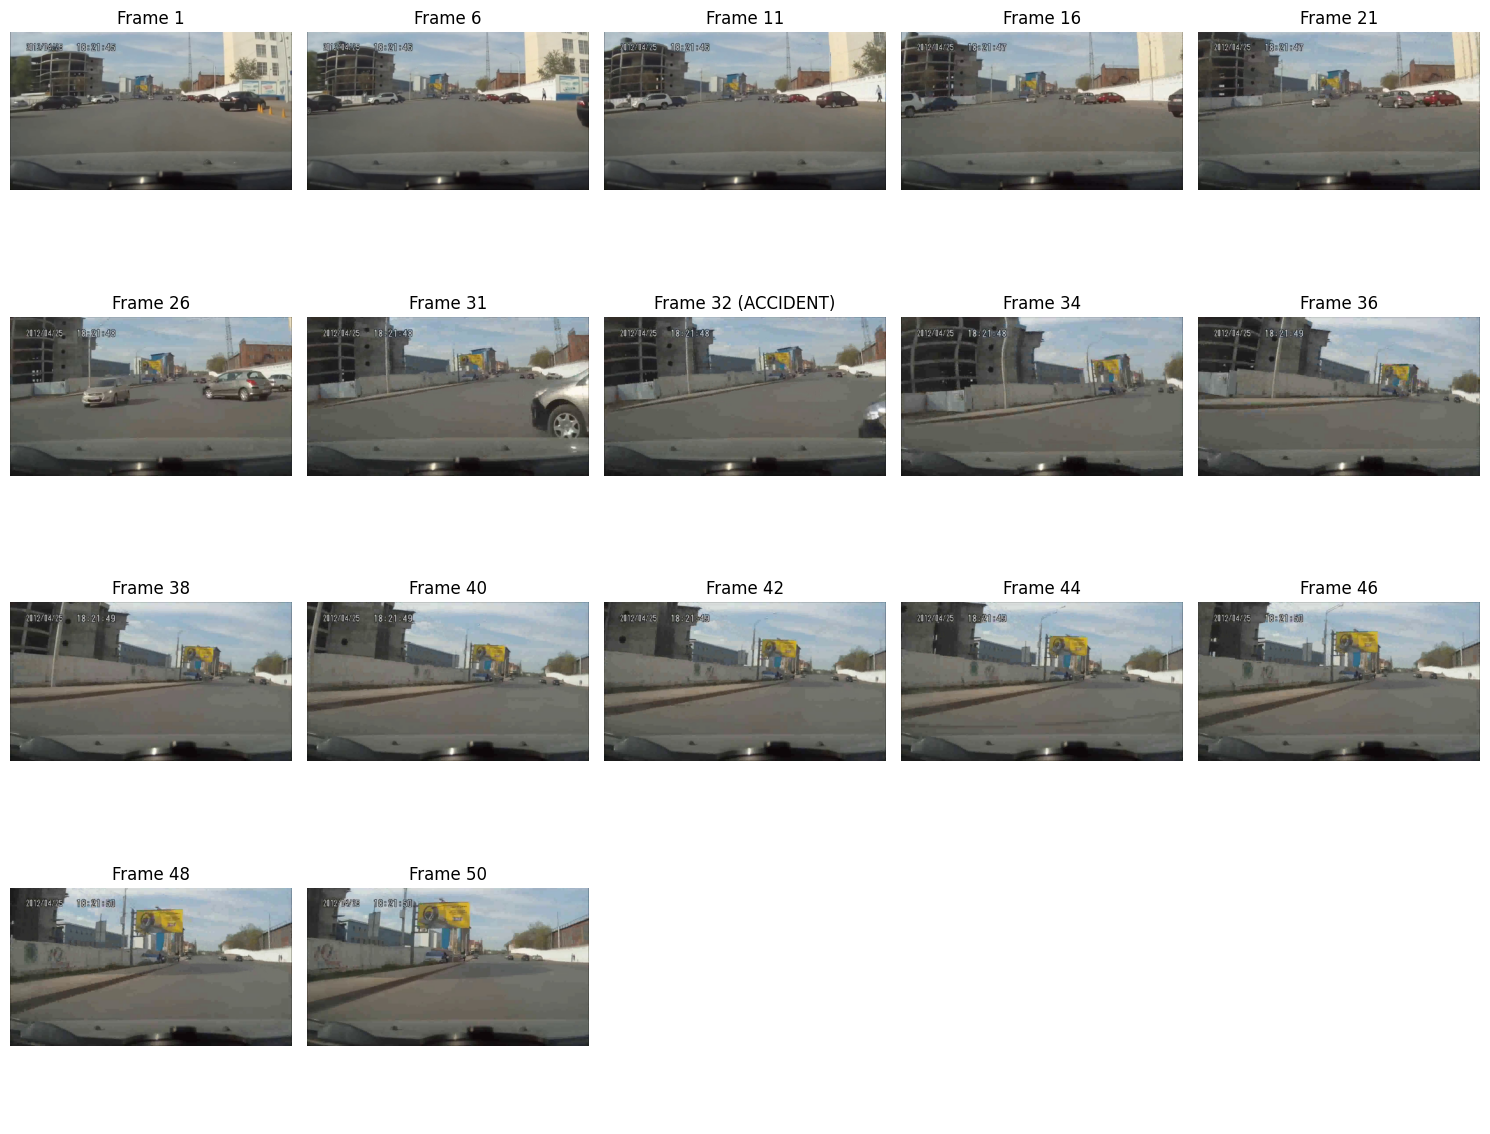

Processed frames: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]. Done.

[[ Generated Report ]]

From the provided frames, it appears that the video captures a road accident involving multiple vehicles. The sequence progresses as the camera moves down the road, capturing the events unfold in real-time. Initially, several cars can be seen moving along the road, with a cyclist on the side, seemingly uninvolved. The environment suggests a city or industrial area, with buildings and advertisements in the background. 

As the video progresses, a significant event occurs around frame 6. A collision appears to happen on the road, indicated by the sudden movement and positioning of the vehicles involved. The frames show some cars altering their trajectories, suggesting a crash. This collision might have been caused by a vehicle losing control or improper lane changes and potentially another vehicle in its path.

In the following frames, multiple vehicles come to a stop in the afte

In [26]:
get_report(3, recursive=False, display_img=True)

In [27]:
get_report(3, recursive=True, display_img=False)


Processing batch 01 - frames ['01', '03']...
Processing batch 02 - frames ['05', '07']...
Processing batch 03 - frames ['09', '11']...
Processing batch 04 - frames ['13', '15']...
Processing batch 05 - frames ['17', '19']...
Processing batch 06 - frames ['21', '23']...
Processing batch 07 - frames ['25', '27']...
Processing batch 08 - frames ['29', '31']...
Processing batch 09 - frames ['33', '35']...
Processing batch 10 - frames ['37', '39']...
Processing batch 11 - frames ['41', '43']...
Processing batch 12 - frames ['45', '47']...
Processing batch 13 - frames ['49']... Done.

[[ Generated Report ]]

Based on the current frame and analysis of the provided description of prior moments, here’s a description of how the accident happened:

### Key Observations:
1. **Stable Traffic Flow**: Until timestamp 18:21:48 (or prior frames), there were no signs of disruptions, indicating an orderly and uninterrupted traffic flow.
2. **Positioning of Vehicles**: The silver car and other vehicles i